In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np

In [73]:
latent_size = 8
w = h = 256 # output of encoder size
w_h = h_h = 28 # output of encoder size
C = 3
h_dim = 25088

class VAEModel(nn.Module):
    def __init__(self) -> None:
        super(VAEModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 8, stride = 2),
            nn.SiLU(),
            nn.Conv2d(4, 8, kernel_size = 5, stride = 2),
            nn.SiLU(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 2),
            nn.SiLU(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
            nn.SiLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2),
            nn.SiLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2),
            nn.SiLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=5, stride=2),
            nn.SiLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=2, stride=1),
            nn.SiLU()
        )

        self.fc_mu = nn.Linear(h_dim, latent_size)
        self.fc_log_sigma = nn.Linear(h_dim, latent_size)
        self.latent_de = nn.Linear(latent_size, h_dim)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, h_dim)
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

    def decode(self, z):
        z = z.view(-1, 32, w_h, h_h)
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(-1, 1, w, h) # add channel dimension
        mu, log_sigma = self.encode(x) # log sigma is more stable (numerically)
        z = self.reparameterize(mu, log_sigma)
        z = self.latent_de(z)
        x_hat = self.decode(z)
        return x_hat.view(-1, w, h), mu, log_sigma

In [171]:
model = VAEModel()

# Check model
A = torch.randn((10, 256, 256))
B, mu_B, log_sigma_B = model.forward(A)
B.shape, mu_B.shape, log_sigma_B.shape

(torch.Size([10, 256, 256]), torch.Size([10, 8]), torch.Size([10, 8]))

In [172]:
mse_loss = nn.MSELoss(reduction='mean')
def loss_fn(x, x_hat, mu, log_sigma): # input, reconstructed input
    #MSE = mse_loss(x_hat, x)
    BCE = F.binary_cross_entropy_with_logits(x_hat, x, reduction='mean')
    KLD = 0.5*torch.sum(log_sigma.exp() + mu.pow(2) - log_sigma - 1) # KL divergence
    loss = BCE + KLD # reduce both bce and mse
    return loss

In [173]:
def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    #img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[0].imshow(img_0, cmap='gray')
    axs[1].imshow(img_1, cmap='gray')
    fig.canvas.draw()

In [174]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [175]:
def make_train_loader(idx):
    batch_size = 16
    train_data = torch.load(f'augmenteddata/data_chunk_{idx}.pt')
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

In [176]:
def make_dev_loader():
    batch_size = 16
    dev_data = torch.load(f'augmenteddata/data_chunk_{12}.pt')
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return dev_loader

In [177]:
def train_epoch(model, optimizer):
    model.train()
    idxs = np.arange(1, 12)
    np.random.shuffle(idxs)

    losses = 0

    for idx in idxs:
        chunk_losses = 0
        train_loader = make_train_loader(idx)
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, log_sigma = model.forward(x)
            loss = loss_fn(x, x_hat, mu, log_sigma)
            loss.backward()

            optimizer.step()
            chunk_losses += loss.item()
        losses += chunk_losses / len(train_loader)
    return losses / 11

In [178]:
def evaluate(model):
    model.eval()
    losses = 0
    dev_loader = make_dev_loader()
    for x in dev_loader:
        x = x.to(device)
        x_hat, mu, log_sigma = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_sigma)
        losses += loss.item()

    return losses / len(dev_loader)

In [179]:
#model = torch.load('models/model_7_all_chunks_random_12_dev')
train_losses = []
dev_losses = []

In [180]:
from timeit import default_timer as timer
NUM_EPOCHS = 50

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(model)
    dev_losses.append(dev_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Dev loss: {dev_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.594, Dev loss: 0.586, Epoch time = 241.740s
Epoch: 2, Train loss: 0.595, Dev loss: 0.586, Epoch time = 244.143s


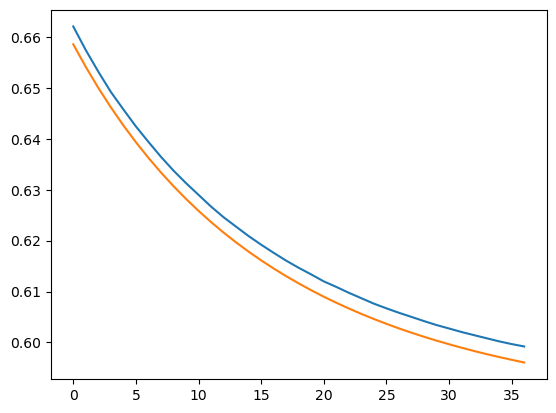

In [146]:
torch.save(model, 'models/model_8_all_chunks_random_12_dev')
torch.save(torch.Tensor(train_losses), 'losses/train_losses_model_8')
torch.save(torch.Tensor(dev_losses), 'losses/dev_losses_model_8')
plt.plot((train_losses))
plt.plot((dev_losses))

tensor(0.1235, device='cuda:0', grad_fn=<MseLossBackward0>)

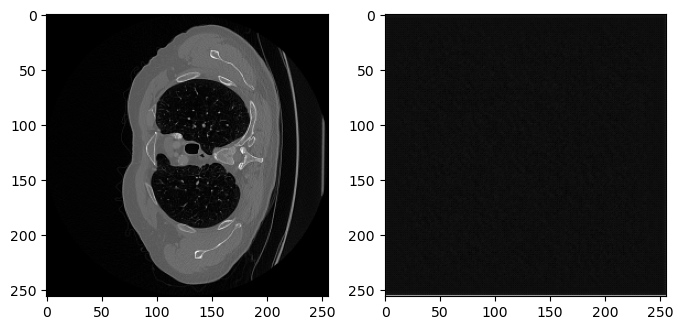

In [150]:
model.eval()
dev_loader = make_dev_loader()
x_test = next(iter(dev_loader))[0].view(1, 256, 256).to(device)
x_hat_test = model.forward(x_test)[0]
draw(x_test.cpu(), x_hat_test.cpu())